# Regression

In [1]:
import pandas as pd

# Чтение файла по частям
chunk_size = 100
chunks = pd.read_csv('/root/blocksnet/tests/data/combined_filtered_data.csv', encoding='utf-8', chunksize=chunk_size)

# Получение первого куска как DataFrame
first_chunk = next(chunks)
first_chunk.head().columns  # Вывод первых строк

Index(['indicator_section_code', 'indicator_section', 'indicator_code',
       'indicator_name', 'region_id', 'region_name', 'mun_level',
       'mun_district', 'municipality', 'oktmo', 'mun_type', 'mun_type_oktmo',
       'oktmo_stable', 'oktmo_history', 'oktmo_year_from', 'oktmo_year_to',
       'year', 'indicator_value', 'indicator_unit', 'indicator_period',
       'comment', 'strashod', 'stdohod', 'zdrav', 'tipotd', 'uslug', 'okpd2',
       'okpdst', 'obroz', 'okved', 'okved2', 'vidtorgv', 'dol', 'tipushr',
       'vozr', 'obras', 'zagr', 'vidfond', 'mosh', 'gilsem', 'spzakmp',
       'vidzych', 'prich', 'vidpost', 'vidych', 'sptorg', 'spzakpr', 'sport',
       'istkoop', 'skoop', 'okpdn', 'vidres', 'mest', 'okfs', 'vidazc',
       'pokdor', 'selmash', 'okei', 'kategor', 'kultur', 'skot', 'post',
       'vidtorg', 'ucheb', 'tipset', 'schil', 'mostep', 'kanal', 'istinv',
       'grup_2', 'migr', 'nazsostv', 'wetwl', 'okogu', 'stash', 'okco'],
      dtype='object')

In [2]:
import pandas as pd

# Открываем файл tep.pickle
tep = pd.read_pickle('/root/blocksnet/tests/data/tep.pickle').fillna(0)
indicators = pd.read_pickle('/root/blocksnet/tests/data/indicators.pickle').fillna(0)

In [3]:
import requests
import json
import pandas as pd

BASE_URL = "https://urban-api.idu.kanootoko.org"

def get_indicators_by_parent(parent_id):
    url = f"{BASE_URL}/api/v1/indicators_by_parent"
    params = {"parent_id": parent_id}
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        return response.json()
    except requests.RequestException as e:
        print(f"Error fetching indicators: {e}")
        return None

def get_indicator_values(territory_id, indicator_ids=None):
    url = f"{BASE_URL}/api/v1/territory/{territory_id}/indicator_values"
    params = {}
    if indicator_ids:
        params["indicator_ids"] = ",".join(map(str, indicator_ids))
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        return response.json()
    except requests.RequestException as e:
        print(f"Error fetching indicator values: {e}")
        return None

def create_indicator_dataframe(territory_ids, indicator_ids):
    data = []
    
    for territory_id in territory_ids:
        values = get_indicator_values(territory_id, indicator_ids)
        if values:
            for value in values:
                data.append({
                    'territory_id': value['territory']['id'],
                    'indicator_name': value['indicator']['name_full'],
                    'value': value['value']
                })
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Pivot to get territories as index and indicators as columns
    df_pivot = df.pivot(index='territory_id', columns='indicator_name', values='value')
    
    return df_pivot

In [4]:
# parent_id = 308
# territory_ids = tep.index.values

# # Get indicators
# indicators = get_indicators_by_parent(parent_id)
# indicator_ids = [indicator["indicator_id"] for indicator in indicators]


# df = create_indicator_dataframe(territory_ids, indicator_ids)
# df

In [5]:
# # Save to CSV (optional)
# df.to_csv('indicator_values.csv')

In [6]:
df = pd.read_csv('indicator_values.csv')
df = df.set_index('territory_id')

In [7]:
indicators = df

In [8]:
import pandas as pd
import numpy as np

# Преобразование в pandas DataFrame, если данные в виде numpy массивов
X = pd.DataFrame(tep) if not isinstance(tep, pd.DataFrame) else tep
Y = pd.DataFrame(indicators) if not isinstance(indicators, pd.DataFrame) else indicators

# Максимальное и минимальное значение для float64
float_max = np.finfo(np.float64).max
float_min = np.finfo(np.float64).min

# Проверка и замена NaN, inf и -inf в X
for col in X.columns:
    # Проверка, является ли колонка числовой
    if np.issubdtype(X[col].dtype, np.number):
        # Замена inf на float_max, -inf на float_min
        X[col] = X[col].replace(np.inf, float_max)
        X[col] = X[col].replace(-np.inf, float_min)
        # Замена NaN на 0
        X[col] = X[col].fillna(0)

# Проверка и замена NaN, inf и -inf в Y
for col in Y.columns:
    # Проверка, является ли колонка числовой
    if np.issubdtype(Y[col].dtype, np.number):
        # Замена inf на float_max, -inf на float_min
        Y[col] = Y[col].replace(np.inf, float_max)
        Y[col] = Y[col].replace(-np.inf, float_min)
        # Замена NaN на 0
        Y[col] = Y[col].fillna(0)

# Удаление полностью пустых колонок
X = X.dropna(axis=1, how='all')
Y = Y.dropna(axis=1, how='all')

In [9]:
# Вычисляем процент нулевых значений для каждого столбца
zero_percentage = (Y == 0).mean()

# Оставляем только столбцы, где процент нулей <= 80%
Y = Y.loc[:, zero_percentage <= 0.8]

In [10]:
# Вычисляем процент нулевых значений для каждого столбца
zero_percentage = (X == 0).mean()

# Оставляем только столбцы, где процент нулей <= 80%
X = X.loc[:, zero_percentage <= 0.8]

In [11]:
X = X.replace([np.inf, -np.inf], np.nan).dropna()
Y = Y.replace([np.inf, -np.inf], np.nan).dropna()

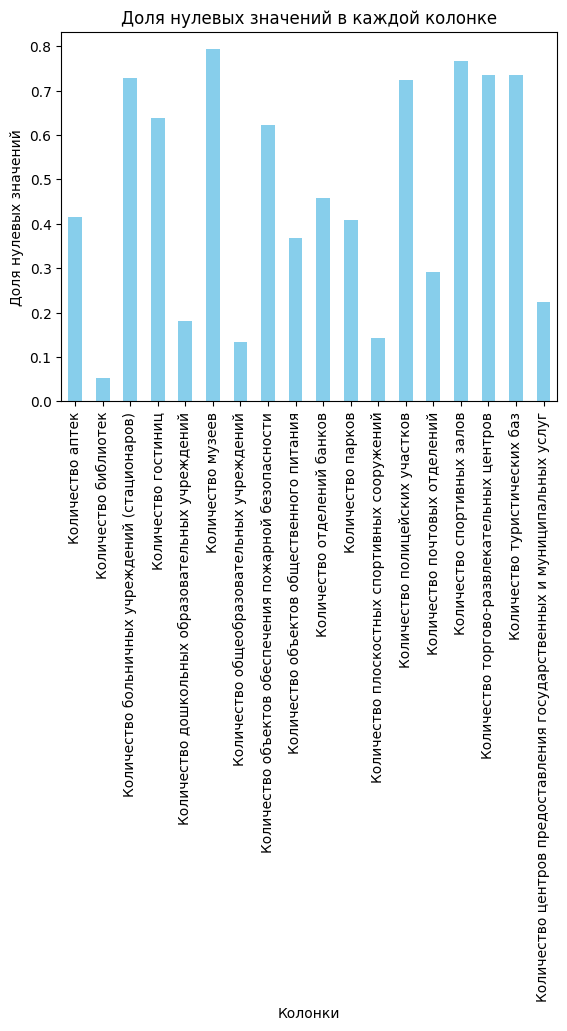

In [12]:
import pandas as pd
import matplotlib.pyplot as plt# Подсчёт количества нулевых значений в каждой колонке
zero_counts = (Y == 0).sum()

# Доля нулевых значений от общего количества в каждой колонке
zero_fraction = zero_counts / len(Y)

# Построение гистограммы
zero_fraction.plot(kind='bar', color='skyblue')
plt.title("Доля нулевых значений в каждой колонке")
plt.xlabel("Колонки")
plt.ylabel("Доля нулевых значений")
plt.show()

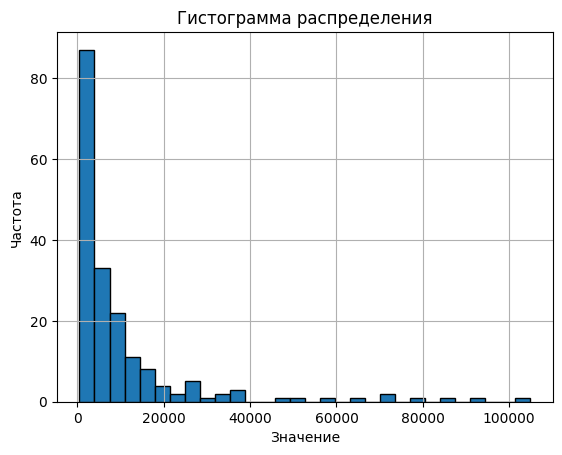

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Построение гистограммы
plt.hist(X['population'], bins=30, edgecolor='black')  # bins — количество столбцов
plt.title('Гистограмма распределения')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.grid(True)
plt.show()


In [14]:
# 1. Объединяем X и Y по столбцам
combined = pd.concat([X, Y], axis=1)

# 2. Фильтруем строки, где есть значения больше 8.988466e+305
filtered = combined[~combined.gt(8.988466e+304).any(axis=1)]

# 3. Разделяем обратно на X и Y
X = filtered[X.columns]
Y = filtered[Y.columns]

In [15]:
filtered.shape

(188, 31)

In [16]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Инициализация StandardScaler
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

# Масштабирование X (tep)
X_columns = X.columns
X_index = X.index
X = scaler_X.fit_transform(X)
X = pd.DataFrame(X, columns=X_columns, index=X_index)

# Масштабирование Y (indicators)
Y_columns = Y.columns
Y_index = Y.index
Y = scaler_Y.fit_transform(Y)
Y = pd.DataFrame(Y, columns=Y_columns, index=Y_index)

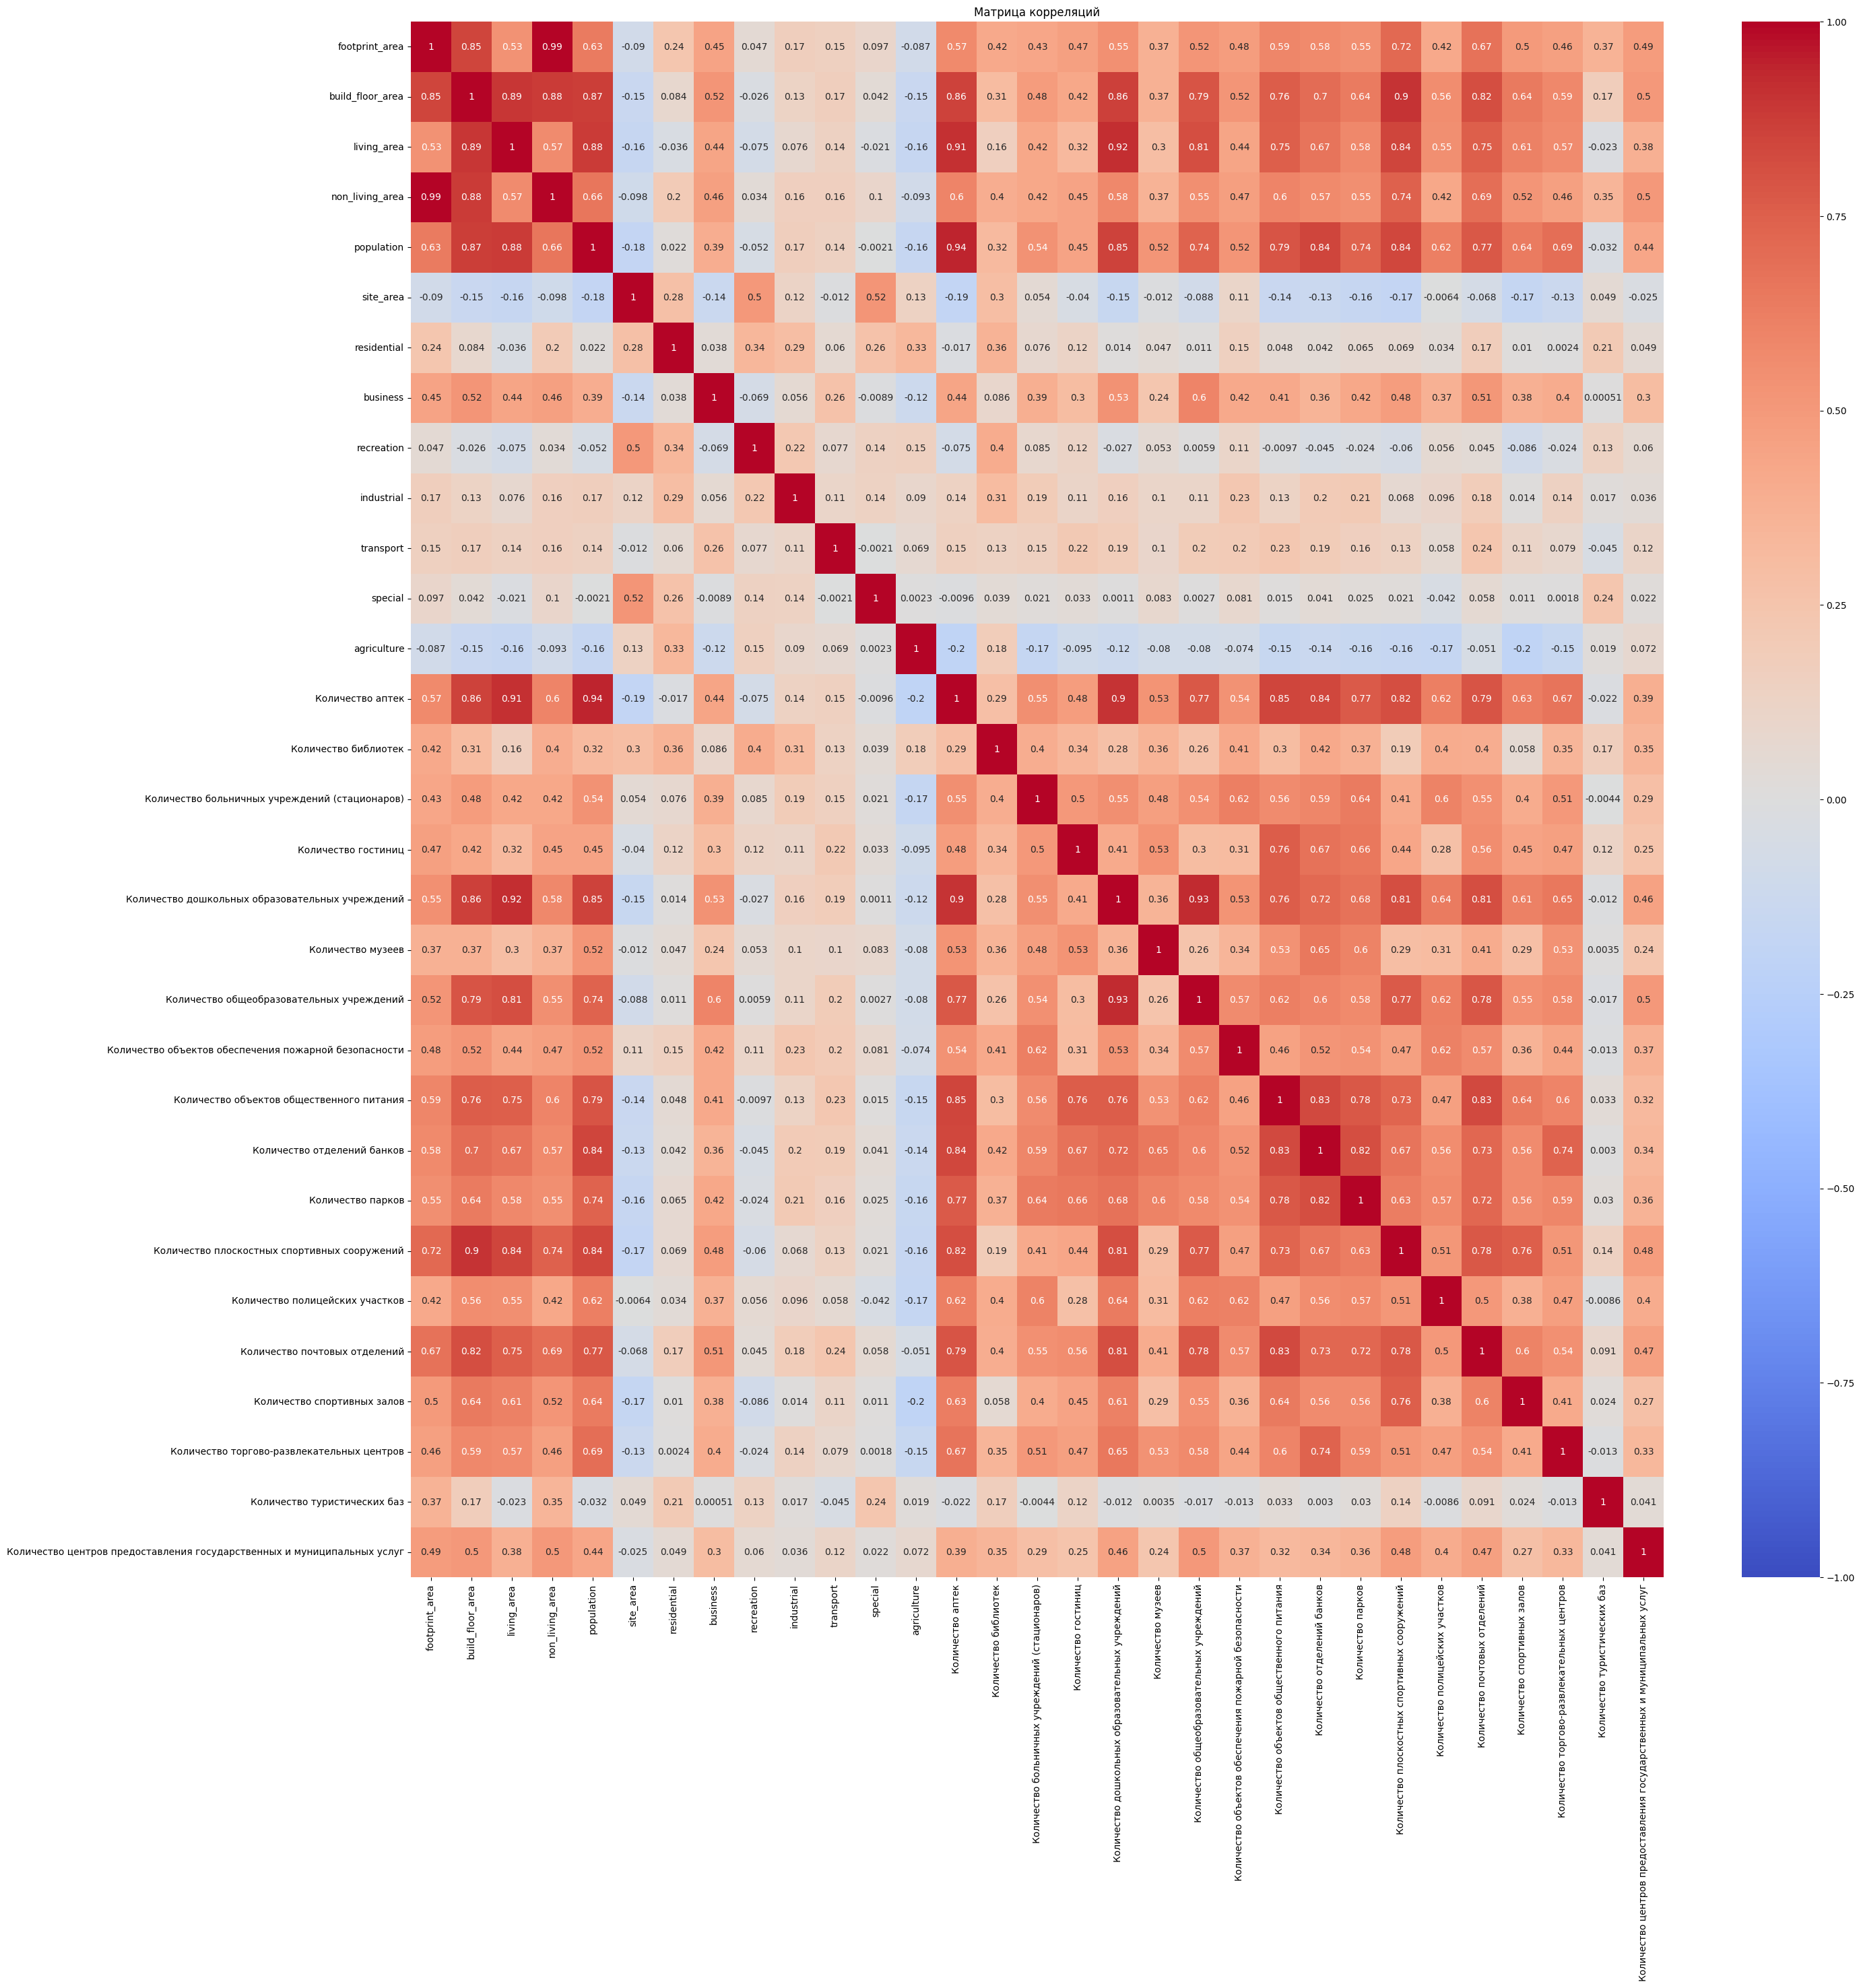

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

numpy_data  = pd.concat([X, Y], axis=1)
df = pd.DataFrame(numpy_data,)
correlation_matrix = df.corr()

plt.figure(figsize=(30, 30)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Матрица корреляций')  
plt.show()

In [18]:
import optuna
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Функция для создания и оценки модели с заданными гиперпараметрами
def objective(trial):
    # Определяем пространство гиперпараметров для оптимизации
    # Используем дискретные значения для дробных параметров
    
    # Для n_estimators, используем дискретные значения
    n_estimators_options = [100, 150, 200, 300, 400, 500]
    n_estimators = trial.suggest_categorical('n_estimators', n_estimators_options)
    
    # Для learning_rate, используем список возможных значений
    learning_rate_options = [0.0001, 0.001, 0.01]
    learning_rate = trial.suggest_categorical('learning_rate', learning_rate_options)
    
    # Для max_depth, используем фиксированный список возможных значений
    max_depth_options = [5, 10, 15]
    max_depth = trial.suggest_categorical('max_depth', max_depth_options)
    
    # Для min_samples_split, используем небольшой список значений
    min_samples_split_options = [ 10, 15, 20]
    min_samples_split = trial.suggest_categorical('min_samples_split', min_samples_split_options)
    
    # Для min_samples_leaf, также используем дискретные значения
    min_samples_leaf_options = [4, 8, 16, 24, 32]
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', min_samples_leaf_options)
    
    # Для subsample, используем фиксированные значения
    subsample_options = [0.5,  0.7, 0.9, 1.0]
    subsample = trial.suggest_categorical('subsample', subsample_options)
    
    # Для max_features, также используем дискретные значения
    max_features_options = [0.5, 0.7, 0.9, 1.0, "sqrt", "log2"]
    max_features = trial.suggest_categorical('max_features', max_features_options)
    
    # Создаем модель с текущими параметрами
    params = {
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'subsample': subsample,
        'max_features': max_features,
        'random_state': 42
    }
    
    gbr = GradientBoostingRegressor(**params)
    multi_gbr = MultiOutputRegressor(gbr)
    
    # Обучаем модель
    multi_gbr.fit(X_train, y_train)
    
    # Делаем предсказания
    y_pred = multi_gbr.predict(X_test)
    
    # Вычисляем среднюю MSE по всем выходным переменным
    mse = mean_squared_error(y_test, y_pred)
    
    return mse

# Предположим, что ваши данные уже загружены и предобработаны
# X - ваши масштабированные входные данные
# Y - ваши масштабированные выходные данные

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42
    )

# # Создаем исследование Optuna
# study = optuna.create_study(direction='minimize')  # Минимизируем MSE
# study.optimize(objective, n_trials=10)  # Количество итераций поиска

# # Выводим лучшие параметры
# print("Лучшие параметры:", study.best_params)
# print("Лучшее значение MSE:", study.best_value)

In [21]:
# Создаем финальную модель с лучшими параметрами
#study.best_params#
best_params = {'n_estimators': 150, 'learning_rate': 0.01, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 8, 'subsample': 0.9, 'max_features': 0.7}
best_gbr = GradientBoostingRegressor(random_state=42, **best_params,loss='huber')
best_multi_gbr = MultiOutputRegressor(best_gbr)

# Обучаем финальную модель
best_multi_gbr.fit(X_train, y_train)

# Делаем предсказания
y_pred = best_multi_gbr.predict(X_test)

# Оценка (MSE для каждого выхода)
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
print(f'Mean Squared Error для каждой целевой переменной: {mse.round(3)}')
print(f'Средняя MSE: {np.mean(mse)}')

Mean Squared Error для каждой целевой переменной: [0.01  0.032 0.019 0.001 0.001 0.027 0.001 0.03  0.002 0.007 0.009 0.001
 0.023 0.004 0.004 0.008 0.029 0.015]
Средняя MSE: 0.012421314829447066


In [53]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
from tqdm import tqdm  # импорт tqdm

def compute_bootstrap_intervals(X_train, y_train, X_test,
                                base_params, B=200,
                                alpha=0.05, random_state=42):
    """
    Возвращает:
      - mean_preds: (n_samples, n_outputs) точечные предсказания на оригинальной модели
      - ci_lower, ci_upper: границы CI для среднего прогноза
      - pi_lower, pi_upper: границы PI для новых наблюдений
    """
    rng = np.random.RandomState(random_state)
    base = GradientBoostingRegressor(random_state=random_state, loss='huber', **base_params)
    model_full = MultiOutputRegressor(base).fit(X_train, y_train)
    mean_preds = model_full.predict(X_test)

    boot_preds = np.zeros((B, X_test.shape[0], y_train.shape[1]))

    print(f"Выполняется бутстрэп ({B} повторов)...")
    for b in tqdm(range(B), desc="Bootstrapping"):
        Xb, yb = resample(X_train, y_train, random_state=rng.randint(0, 1e6))
        base_b = GradientBoostingRegressor(random_state=rng.randint(0, 1e6),
                                           loss='huber', **base_params)
        model_b = MultiOutputRegressor(base_b).fit(Xb, yb)
        boot_preds[b] = model_b.predict(X_test)
    
    lower_q, upper_q = 100 * (alpha/2), 100 * (1 - alpha/2)
    mean_boot = boot_preds.mean(axis=1)
    ci_lower = np.percentile(mean_boot, lower_q, axis=0)
    ci_upper = np.percentile(mean_boot, upper_q, axis=0)
    pi_lower = np.percentile(boot_preds, lower_q, axis=0)
    pi_upper = np.percentile(boot_preds, upper_q, axis=0)

    return mean_preds, ci_lower, ci_upper, pi_lower, pi_upper


# # Применение
# mean_pred, ci_lower, ci_upper, pi_lower, pi_upper = compute_bootstrap_intervals(
#     X_train, y_train, X_test, best_params,
#     B=2, alpha=0.05, random_state=42
# )

# Оценим стандартный MSE
mse = mean_squared_error(y_test, mean_pred, multioutput='raw_values')
print(f"MSE каждой цели: {mse.round(3)}; Средняя MSE: {mse.mean():.3f}")

exaple_idx = 10
# Выведем доверительные интервалы для всех целей (выходов)
for i, name in enumerate(y_test.columns.values):
    print(f"\nДля {name}:")
    print(f"Среднее предсказание: {mean_pred[exaple_idx, i]:.3f}")
    print(f"95% CI для среднего: [{ci_lower[i]:.3f}, {ci_upper[i]:.3f}]")
    print(f"95% PI для нового наблюдения: [{pi_lower[exaple_idx, i]:.3f}, {pi_upper[exaple_idx, i]:.3f}]")


MSE каждой цели: [0.01  0.032 0.019 0.001 0.001 0.027 0.001 0.03  0.002 0.007 0.009 0.001
 0.023 0.004 0.004 0.008 0.029 0.015]; Средняя MSE: 0.012

Для Количество аптек:
Среднее предсказание: 0.019
95% CI для среднего: [0.037, 0.041]
95% PI для нового наблюдения: [0.015, 0.016]

Для Количество библиотек:
Среднее предсказание: 0.247
95% CI для среднего: [0.233, 0.238]
95% PI для нового наблюдения: [0.176, 0.178]

Для Количество больничных учреждений (стационаров):
Среднее предсказание: 0.024
95% CI для среднего: [0.051, 0.054]
95% PI для нового наблюдения: [0.020, 0.030]

Для Количество гостиниц:
Среднее предсказание: 0.007
95% CI для среднего: [0.020, 0.022]
95% PI для нового наблюдения: [0.001, 0.014]

Для Количество дошкольных образовательных учреждений:
Среднее предсказание: 0.020
95% CI для среднего: [0.042, 0.045]
95% PI для нового наблюдения: [0.023, 0.028]

Для Количество музеев:
Среднее предсказание: 0.012
95% CI для среднего: [0.025, 0.028]
95% PI для нового наблюдения: [0.02

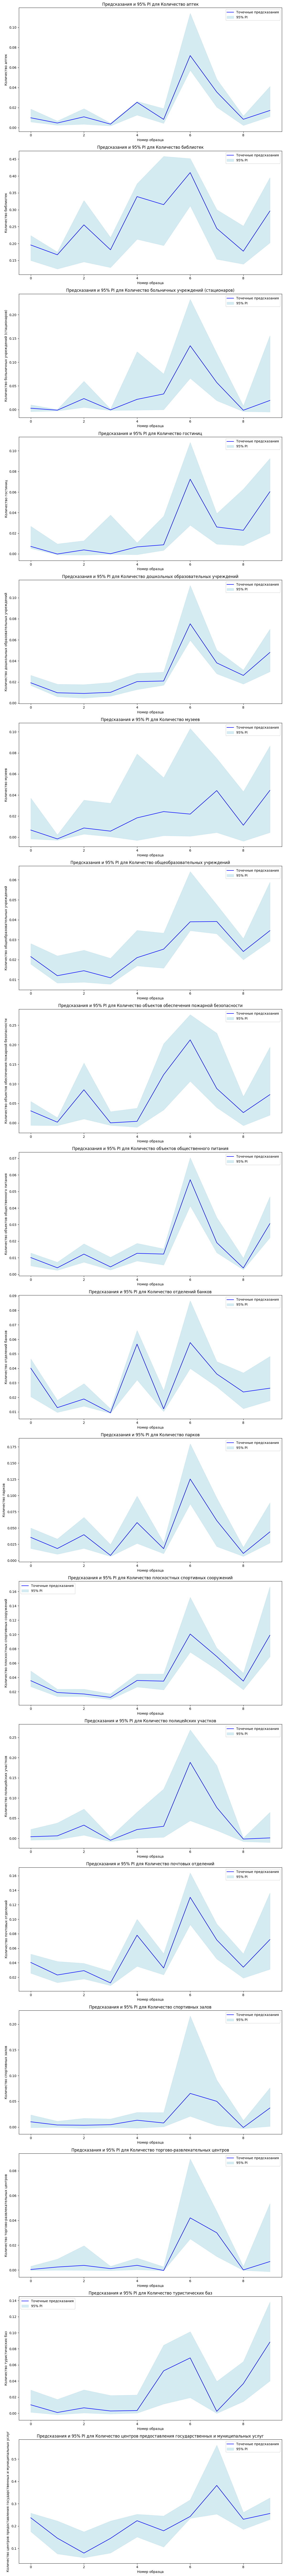

In [56]:
import numpy as np
import matplotlib.pyplot as plt

def plot_prediction_intervals(X_test, mean_preds, pi_lower, pi_upper, column_names):
    """
    Строит графики для предсказательных интервалов (PI) для каждого выхода, используя имена колонок.

    X_test — тестовые данные, shape = (n_samples, n_features)
    mean_preds — точечные предсказания, shape = (n_samples, n_outputs)
    pi_lower — нижняя граница PI, shape = (n_samples, n_outputs)
    pi_upper — верхняя граница PI, shape = (n_samples, n_outputs)
    column_names — список с именами колонок (выходных переменных)
    """
    # Предположим, что для визуализации будем отображать только первые несколько тестовых точек
    n_samples = min(X_test.shape[0], 10)  # Выберем не более 10 точек для графиков
    
    plt.figure(figsize=(12, 6 * len(column_names)))  # Размер графика зависит от количества выходов
    
    for i, col_name in enumerate(column_names):
        plt.subplot(len(column_names), 1, i + 1)
        
        # Построение графика для i-го выхода
        plt.plot(np.arange(n_samples), mean_preds[:n_samples, i], label='Точечные предсказания', color='blue')
        plt.fill_between(np.arange(n_samples), pi_lower[:n_samples, i], pi_upper[:n_samples, i], 
                         color='lightblue', alpha=0.5, label='95% PI')
        
        plt.title(f'Предсказания и 95% PI для {col_name}')
        plt.xlabel('Номер образца')
        plt.ylabel(col_name)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

column_names = y_train.columns.tolist()

plot_prediction_intervals(X_test, mean_pred, pi_lo, pi_hi, column_names=y_train.columns.tolist())



Анализ для Количество аптек:
Тест Шапиро-Уилка: статистика = 0.471, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Тест Колмогорова-Смирнова: статистика = 0.355, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Тест Андерсона-Дарлинга: статистика = 7.407
  => Остатки НЕ распределены нормально (статистика > 0.529 при уровне значимости 15.0%)
  => Остатки НЕ распределены нормально (статистика > 0.603 при уровне значимости 10.0%)
  => Остатки НЕ распределены нормально (статистика > 0.723 при уровне значимости 5.0%)
  => Остатки НЕ распределены нормально (статистика > 0.844 при уровне значимости 2.5%)
  => Остатки НЕ распределены нормально (статистика > 1.004 при уровне значимости 1.0%)
Тест Д’Агостино K²: статистика = 60.745, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Асимметрия (Skewness): 3.795 (должно быть близко к 0 для нормального)
Эксцесс (Kurtosis): 14.871 (должно быть близко к 0 для нормального)


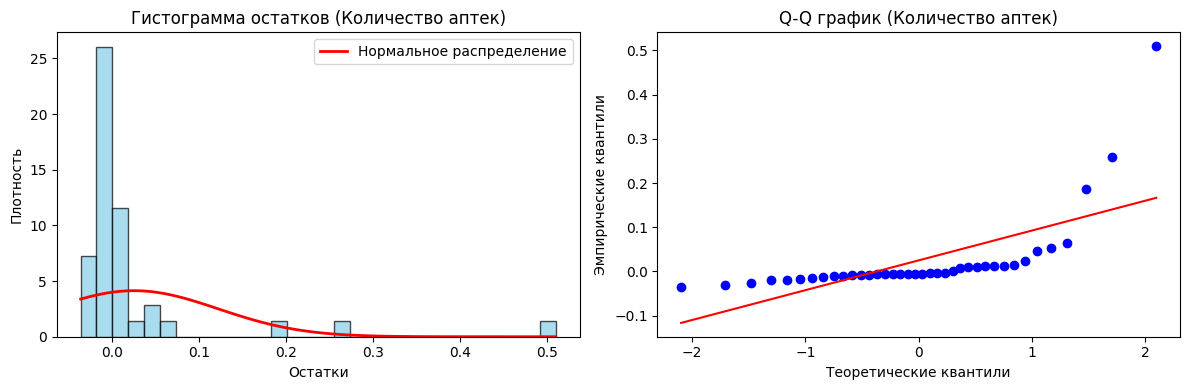


Анализ для Количество библиотек:
Тест Шапиро-Уилка: статистика = 0.888, p-значение = 0.001
  => Остатки НЕ распределены нормально (p < 0.05)
Тест Колмогорова-Смирнова: статистика = 0.195, p-значение = 0.096
  => Нет оснований отвергать нормальность (p >= 0.05)
Тест Андерсона-Дарлинга: статистика = 1.707
  => Остатки НЕ распределены нормально (статистика > 0.529 при уровне значимости 15.0%)
  => Остатки НЕ распределены нормально (статистика > 0.603 при уровне значимости 10.0%)
  => Остатки НЕ распределены нормально (статистика > 0.723 при уровне значимости 5.0%)
  => Остатки НЕ распределены нормально (статистика > 0.844 при уровне значимости 2.5%)
  => Остатки НЕ распределены нормально (статистика > 1.004 при уровне значимости 1.0%)
Тест Д’Агостино K²: статистика = 8.076, p-значение = 0.018
  => Остатки НЕ распределены нормально (p < 0.05)
Асимметрия (Skewness): 0.981 (должно быть близко к 0 для нормального)
Эксцесс (Kurtosis): 0.701 (должно быть близко к 0 для нормального)


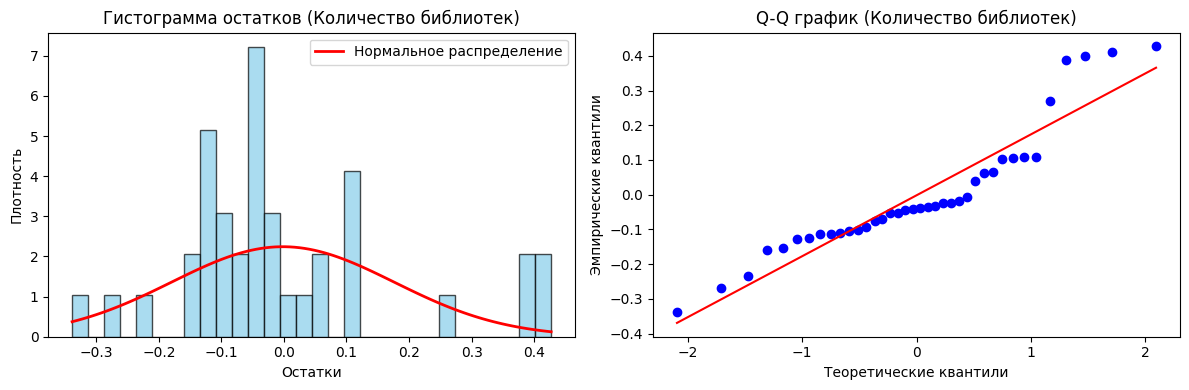


Анализ для Количество больничных учреждений (стационаров):
Тест Шапиро-Уилка: статистика = 0.854, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Тест Колмогорова-Смирнова: статистика = 0.316, p-значение = 0.001
  => Остатки НЕ распределены нормально (p < 0.05)
Тест Андерсона-Дарлинга: статистика = 2.406
  => Остатки НЕ распределены нормально (статистика > 0.529 при уровне значимости 15.0%)
  => Остатки НЕ распределены нормально (статистика > 0.603 при уровне значимости 10.0%)
  => Остатки НЕ распределены нормально (статистика > 0.723 при уровне значимости 5.0%)
  => Остатки НЕ распределены нормально (статистика > 0.844 при уровне значимости 2.5%)
  => Остатки НЕ распределены нормально (статистика > 1.004 при уровне значимости 1.0%)
Тест Д’Агостино K²: статистика = 13.018, p-значение = 0.001
  => Остатки НЕ распределены нормально (p < 0.05)
Асимметрия (Skewness): 1.238 (должно быть близко к 0 для нормального)
Эксцесс (Kurtosis): 1.481 (должно быть близко к 0 для н

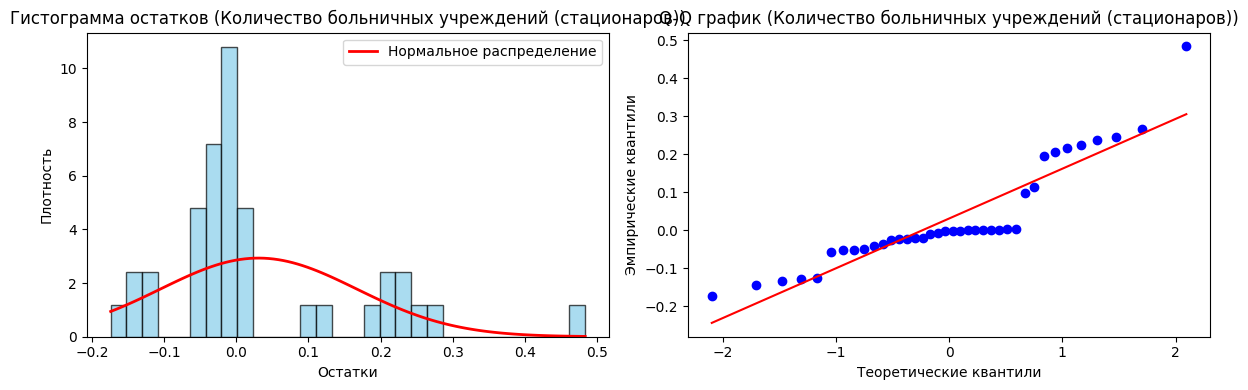


Анализ для Количество гостиниц:
Тест Шапиро-Уилка: статистика = 0.778, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Тест Колмогорова-Смирнова: статистика = 0.270, p-значение = 0.006
  => Остатки НЕ распределены нормально (p < 0.05)
Тест Андерсона-Дарлинга: статистика = 3.013
  => Остатки НЕ распределены нормально (статистика > 0.529 при уровне значимости 15.0%)
  => Остатки НЕ распределены нормально (статистика > 0.603 при уровне значимости 10.0%)
  => Остатки НЕ распределены нормально (статистика > 0.723 при уровне значимости 5.0%)
  => Остатки НЕ распределены нормально (статистика > 0.844 при уровне значимости 2.5%)
  => Остатки НЕ распределены нормально (статистика > 1.004 при уровне значимости 1.0%)
Тест Д’Агостино K²: статистика = 26.893, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Асимметрия (Skewness): 1.699 (должно быть близко к 0 для нормального)
Эксцесс (Kurtosis): 5.199 (должно быть близко к 0 для нормального)


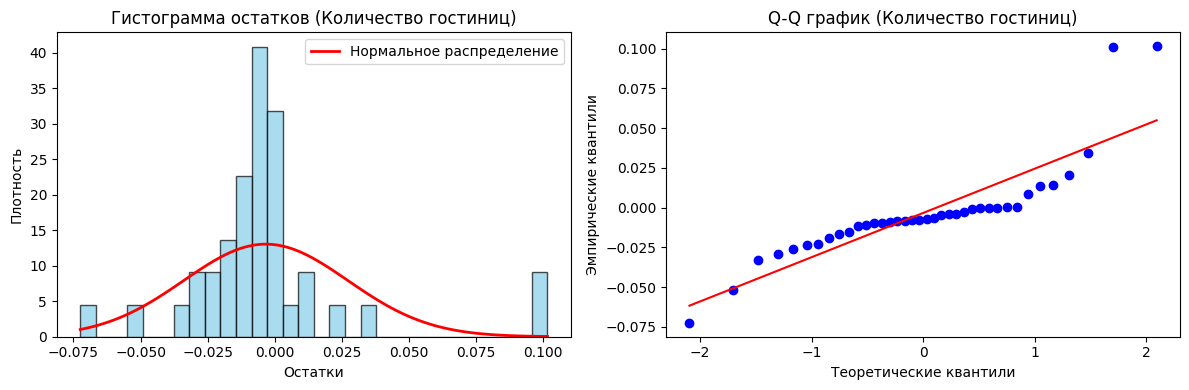


Анализ для Количество дошкольных образовательных учреждений:
Тест Шапиро-Уилка: статистика = 0.810, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Тест Колмогорова-Смирнова: статистика = 0.199, p-значение = 0.086
  => Нет оснований отвергать нормальность (p >= 0.05)
Тест Андерсона-Дарлинга: статистика = 2.295
  => Остатки НЕ распределены нормально (статистика > 0.529 при уровне значимости 15.0%)
  => Остатки НЕ распределены нормально (статистика > 0.603 при уровне значимости 10.0%)
  => Остатки НЕ распределены нормально (статистика > 0.723 при уровне значимости 5.0%)
  => Остатки НЕ распределены нормально (статистика > 0.844 при уровне значимости 2.5%)
  => Остатки НЕ распределены нормально (статистика > 1.004 при уровне значимости 1.0%)
Тест Д’Агостино K²: статистика = 26.348, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Асимметрия (Skewness): 1.856 (должно быть близко к 0 для нормального)
Эксцесс (Kurtosis): 4.014 (должно быть близко к 0

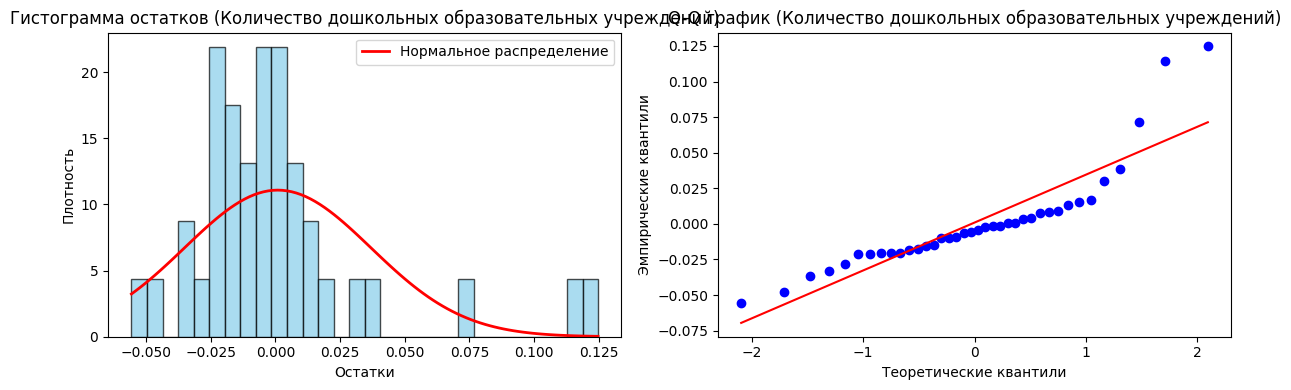


Анализ для Количество музеев:
Тест Шапиро-Уилка: статистика = 0.432, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Тест Колмогорова-Смирнова: статистика = 0.421, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Тест Андерсона-Дарлинга: статистика = 8.029
  => Остатки НЕ распределены нормально (статистика > 0.529 при уровне значимости 15.0%)
  => Остатки НЕ распределены нормально (статистика > 0.603 при уровне значимости 10.0%)
  => Остатки НЕ распределены нормально (статистика > 0.723 при уровне значимости 5.0%)
  => Остатки НЕ распределены нормально (статистика > 0.844 при уровне значимости 2.5%)
  => Остатки НЕ распределены нормально (статистика > 1.004 при уровне значимости 1.0%)
Тест Д’Агостино K²: статистика = 64.876, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Асимметрия (Skewness): 4.078 (должно быть близко к 0 для нормального)
Эксцесс (Kurtosis): 16.843 (должно быть близко к 0 для нормального)


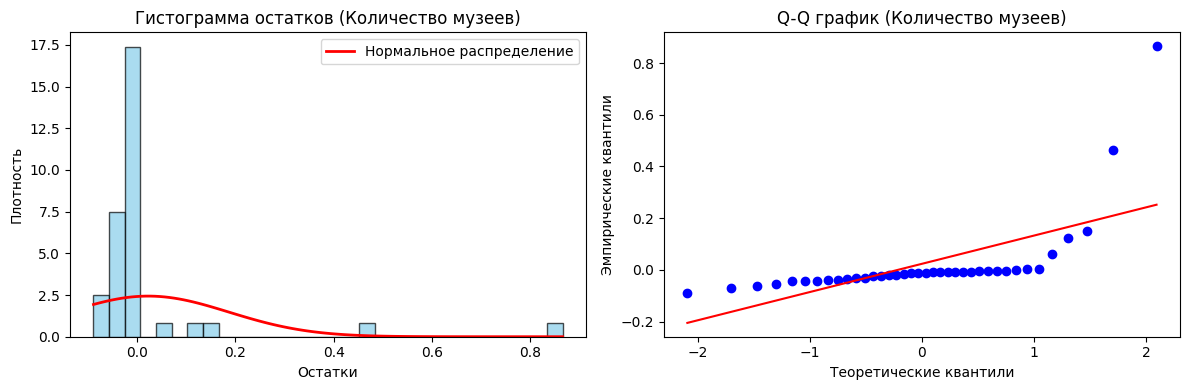


Анализ для Количество общеобразовательных учреждений:
Тест Шапиро-Уилка: статистика = 0.810, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Тест Колмогорова-Смирнова: статистика = 0.188, p-значение = 0.120
  => Нет оснований отвергать нормальность (p >= 0.05)
Тест Андерсона-Дарлинга: статистика = 1.569
  => Остатки НЕ распределены нормально (статистика > 0.529 при уровне значимости 15.0%)
  => Остатки НЕ распределены нормально (статистика > 0.603 при уровне значимости 10.0%)
  => Остатки НЕ распределены нормально (статистика > 0.723 при уровне значимости 5.0%)
  => Остатки НЕ распределены нормально (статистика > 0.844 при уровне значимости 2.5%)
  => Остатки НЕ распределены нормально (статистика > 1.004 при уровне значимости 1.0%)
Тест Д’Агостино K²: статистика = 36.308, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Асимметрия (Skewness): 2.230 (должно быть близко к 0 для нормального)
Эксцесс (Kurtosis): 7.226 (должно быть близко к 0 для но

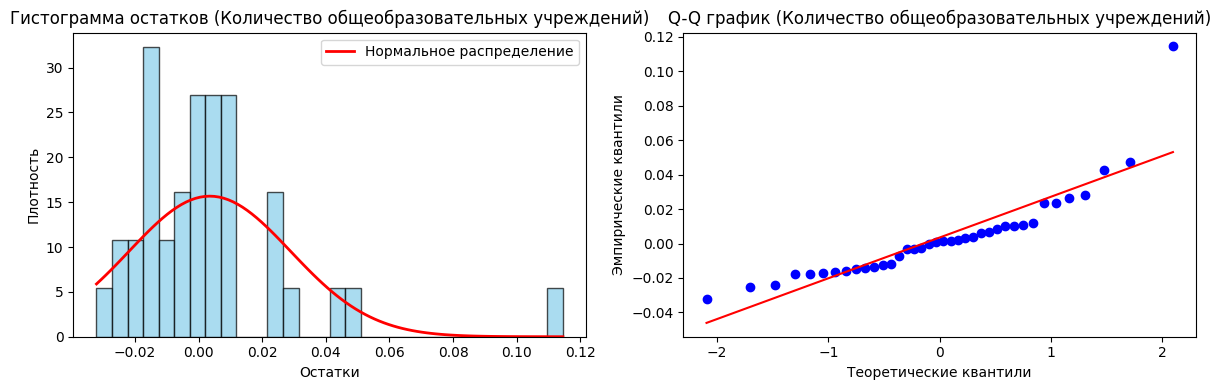


Анализ для Количество объектов обеспечения пожарной безопасности:
Тест Шапиро-Уилка: статистика = 0.919, p-значение = 0.009
  => Остатки НЕ распределены нормально (p < 0.05)
Тест Колмогорова-Смирнова: статистика = 0.245, p-значение = 0.017
  => Остатки НЕ распределены нормально (p < 0.05)
Тест Андерсона-Дарлинга: статистика = 1.597
  => Остатки НЕ распределены нормально (статистика > 0.529 при уровне значимости 15.0%)
  => Остатки НЕ распределены нормально (статистика > 0.603 при уровне значимости 10.0%)
  => Остатки НЕ распределены нормально (статистика > 0.723 при уровне значимости 5.0%)
  => Остатки НЕ распределены нормально (статистика > 0.844 при уровне значимости 2.5%)
  => Остатки НЕ распределены нормально (статистика > 1.004 при уровне значимости 1.0%)
Тест Д’Агостино K²: статистика = 2.289, p-значение = 0.318
  => Нет оснований отвергать нормальность (p >= 0.05)
Асимметрия (Skewness): 0.548 (должно быть близко к 0 для нормального)
Эксцесс (Kurtosis): -0.289 (должно быть близк

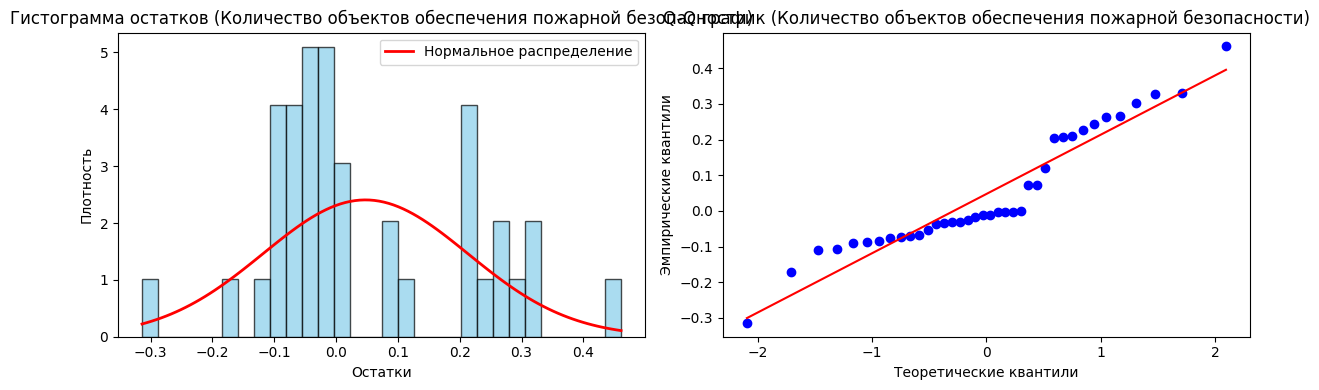


Анализ для Количество объектов общественного питания:
Тест Шапиро-Уилка: статистика = 0.546, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Тест Колмогорова-Смирнова: статистика = 0.315, p-значение = 0.001
  => Остатки НЕ распределены нормально (p < 0.05)
Тест Андерсона-Дарлинга: статистика = 5.382
  => Остатки НЕ распределены нормально (статистика > 0.529 при уровне значимости 15.0%)
  => Остатки НЕ распределены нормально (статистика > 0.603 при уровне значимости 10.0%)
  => Остатки НЕ распределены нормально (статистика > 0.723 при уровне значимости 5.0%)
  => Остатки НЕ распределены нормально (статистика > 0.844 при уровне значимости 2.5%)
  => Остатки НЕ распределены нормально (статистика > 1.004 при уровне значимости 1.0%)
Тест Д’Агостино K²: статистика = 63.862, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Асимметрия (Skewness): 3.931 (должно быть близко к 0 для нормального)
Эксцесс (Kurtosis): 17.281 (должно быть близко к 0 для норма

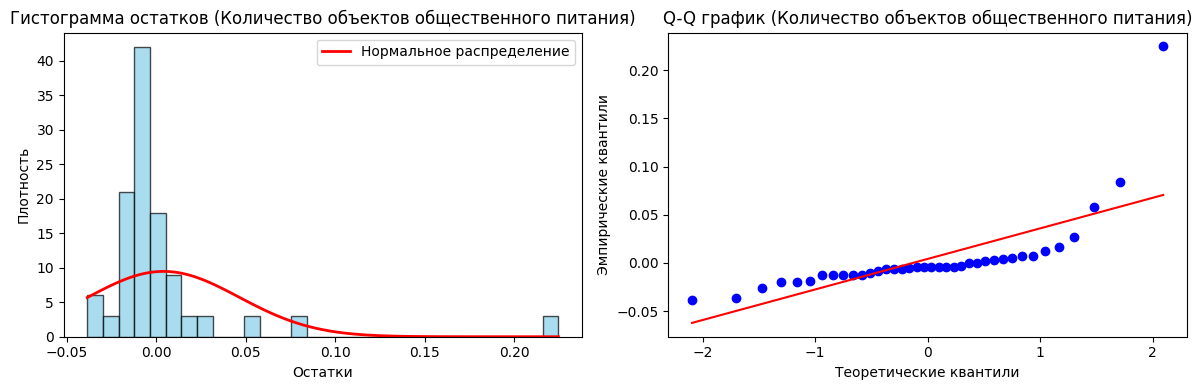


Анализ для Количество отделений банков:
Тест Шапиро-Уилка: статистика = 0.546, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Тест Колмогорова-Смирнова: статистика = 0.276, p-значение = 0.005
  => Остатки НЕ распределены нормально (p < 0.05)
Тест Андерсона-Дарлинга: статистика = 5.813
  => Остатки НЕ распределены нормально (статистика > 0.529 при уровне значимости 15.0%)
  => Остатки НЕ распределены нормально (статистика > 0.603 при уровне значимости 10.0%)
  => Остатки НЕ распределены нормально (статистика > 0.723 при уровне значимости 5.0%)
  => Остатки НЕ распределены нормально (статистика > 0.844 при уровне значимости 2.5%)
  => Остатки НЕ распределены нормально (статистика > 1.004 при уровне значимости 1.0%)
Тест Д’Агостино K²: статистика = 55.801, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Асимметрия (Skewness): 3.499 (должно быть близко к 0 для нормального)
Эксцесс (Kurtosis): 12.478 (должно быть близко к 0 для нормального)


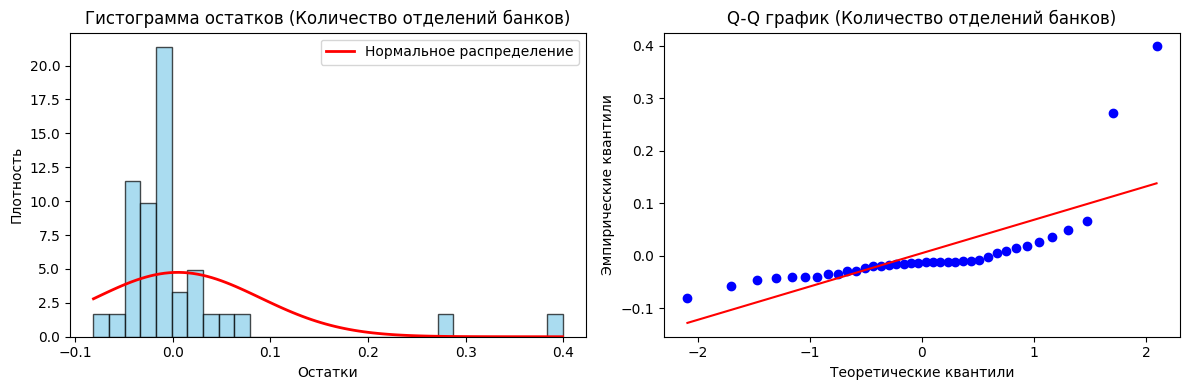


Анализ для Количество парков:
Тест Шапиро-Уилка: статистика = 0.756, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Тест Колмогорова-Смирнова: статистика = 0.238, p-значение = 0.022
  => Остатки НЕ распределены нормально (p < 0.05)
Тест Андерсона-Дарлинга: статистика = 3.252
  => Остатки НЕ распределены нормально (статистика > 0.529 при уровне значимости 15.0%)
  => Остатки НЕ распределены нормально (статистика > 0.603 при уровне значимости 10.0%)
  => Остатки НЕ распределены нормально (статистика > 0.723 при уровне значимости 5.0%)
  => Остатки НЕ распределены нормально (статистика > 0.844 при уровне значимости 2.5%)
  => Остатки НЕ распределены нормально (статистика > 1.004 при уровне значимости 1.0%)
Тест Д’Агостино K²: статистика = 26.185, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Асимметрия (Skewness): 1.953 (должно быть близко к 0 для нормального)
Эксцесс (Kurtosis): 3.436 (должно быть близко к 0 для нормального)


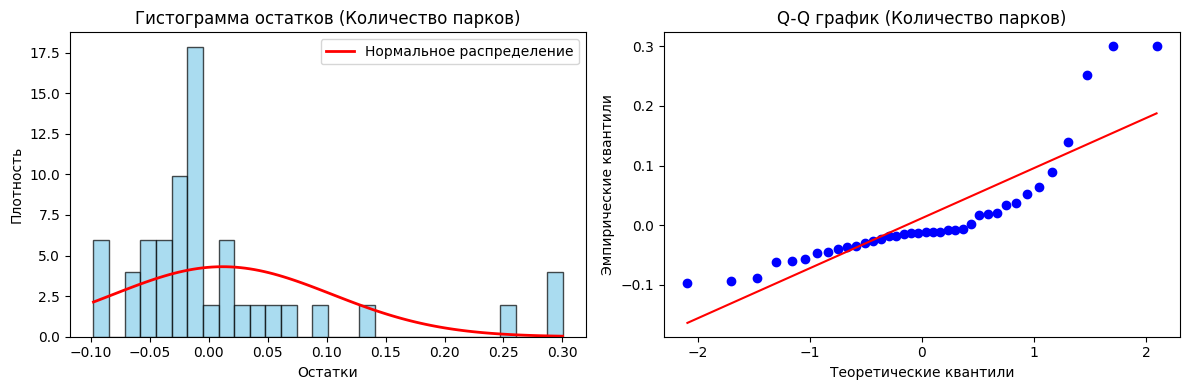


Анализ для Количество плоскостных спортивных сооружений:
Тест Шапиро-Уилка: статистика = 0.782, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Тест Колмогорова-Смирнова: статистика = 0.246, p-значение = 0.016
  => Остатки НЕ распределены нормально (p < 0.05)
Тест Андерсона-Дарлинга: статистика = 2.854
  => Остатки НЕ распределены нормально (статистика > 0.529 при уровне значимости 15.0%)
  => Остатки НЕ распределены нормально (статистика > 0.603 при уровне значимости 10.0%)
  => Остатки НЕ распределены нормально (статистика > 0.723 при уровне значимости 5.0%)
  => Остатки НЕ распределены нормально (статистика > 0.844 при уровне значимости 2.5%)
  => Остатки НЕ распределены нормально (статистика > 1.004 при уровне значимости 1.0%)
Тест Д’Агостино K²: статистика = 26.832, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Асимметрия (Skewness): 1.941 (должно быть близко к 0 для нормального)
Эксцесс (Kurtosis): 3.788 (должно быть близко к 0 для нор

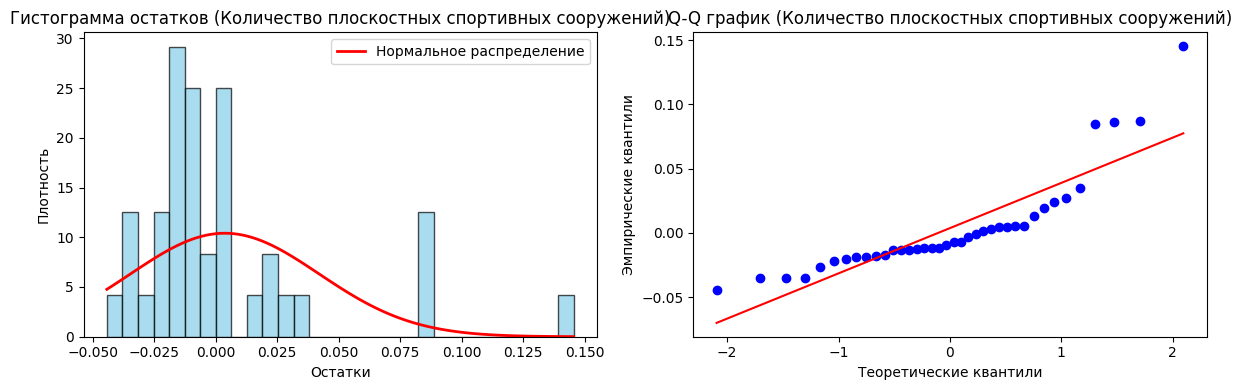


Анализ для Количество полицейских участков:
Тест Шапиро-Уилка: статистика = 0.815, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Тест Колмогорова-Смирнова: статистика = 0.321, p-значение = 0.001
  => Остатки НЕ распределены нормально (p < 0.05)
Тест Андерсона-Дарлинга: статистика = 3.378
  => Остатки НЕ распределены нормально (статистика > 0.529 при уровне значимости 15.0%)
  => Остатки НЕ распределены нормально (статистика > 0.603 при уровне значимости 10.0%)
  => Остатки НЕ распределены нормально (статистика > 0.723 при уровне значимости 5.0%)
  => Остатки НЕ распределены нормально (статистика > 0.844 при уровне значимости 2.5%)
  => Остатки НЕ распределены нормально (статистика > 1.004 при уровне значимости 1.0%)
Тест Д’Агостино K²: статистика = 9.804, p-значение = 0.007
  => Остатки НЕ распределены нормально (p < 0.05)
Асимметрия (Skewness): 1.123 (должно быть близко к 0 для нормального)
Эксцесс (Kurtosis): 0.774 (должно быть близко к 0 для нормального)


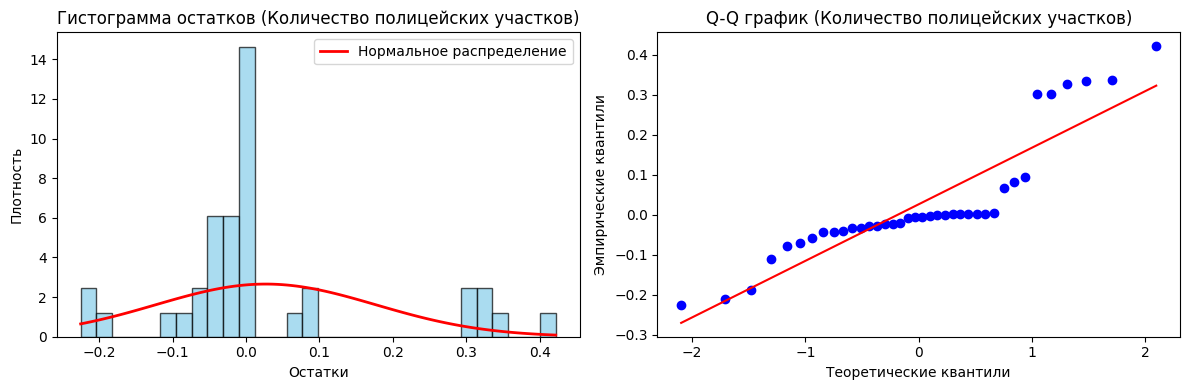


Анализ для Количество почтовых отделений:
Тест Шапиро-Уилка: статистика = 0.865, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Тест Колмогорова-Смирнова: статистика = 0.155, p-значение = 0.289
  => Нет оснований отвергать нормальность (p >= 0.05)
Тест Андерсона-Дарлинга: статистика = 1.567
  => Остатки НЕ распределены нормально (статистика > 0.529 при уровне значимости 15.0%)
  => Остатки НЕ распределены нормально (статистика > 0.603 при уровне значимости 10.0%)
  => Остатки НЕ распределены нормально (статистика > 0.723 при уровне значимости 5.0%)
  => Остатки НЕ распределены нормально (статистика > 0.844 при уровне значимости 2.5%)
  => Остатки НЕ распределены нормально (статистика > 1.004 при уровне значимости 1.0%)
Тест Д’Агостино K²: статистика = 23.127, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Асимметрия (Skewness): 1.557 (должно быть близко к 0 для нормального)
Эксцесс (Kurtosis): 4.122 (должно быть близко к 0 для нормального)


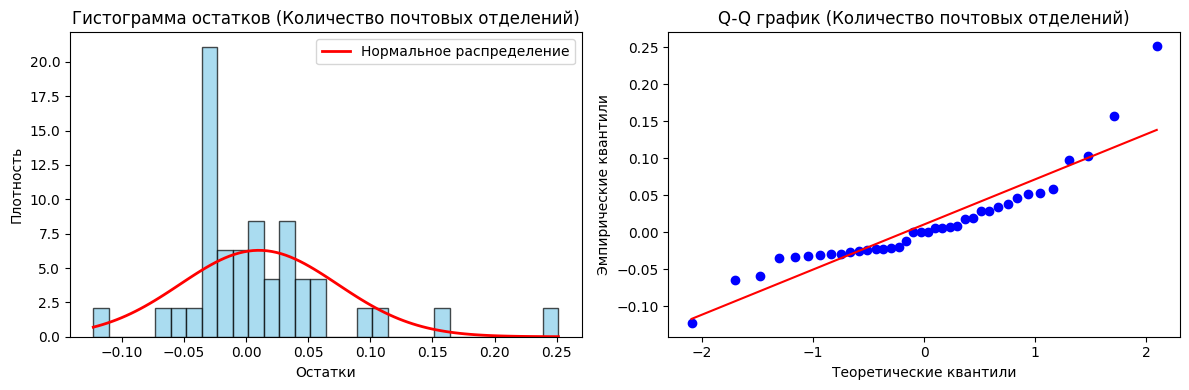


Анализ для Количество спортивных залов:
Тест Шапиро-Уилка: статистика = 0.697, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Тест Колмогорова-Смирнова: статистика = 0.302, p-значение = 0.001
  => Остатки НЕ распределены нормально (p < 0.05)
Тест Андерсона-Дарлинга: статистика = 4.592
  => Остатки НЕ распределены нормально (статистика > 0.529 при уровне значимости 15.0%)
  => Остатки НЕ распределены нормально (статистика > 0.603 при уровне значимости 10.0%)
  => Остатки НЕ распределены нормально (статистика > 0.723 при уровне значимости 5.0%)
  => Остатки НЕ распределены нормально (статистика > 0.844 при уровне значимости 2.5%)
  => Остатки НЕ распределены нормально (статистика > 1.004 при уровне значимости 1.0%)
Тест Д’Агостино K²: статистика = 19.034, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Асимметрия (Skewness): 0.507 (должно быть близко к 0 для нормального)
Эксцесс (Kurtosis): 8.096 (должно быть близко к 0 для нормального)


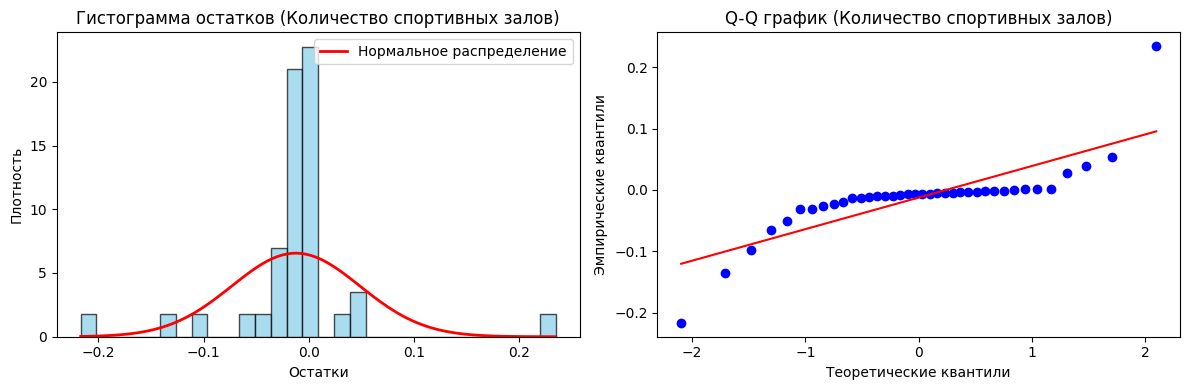


Анализ для Количество торгово-развлекательных центров:
Тест Шапиро-Уилка: статистика = 0.405, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Тест Колмогорова-Смирнова: статистика = 0.441, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Тест Андерсона-Дарлинга: статистика = 8.765
  => Остатки НЕ распределены нормально (статистика > 0.529 при уровне значимости 15.0%)
  => Остатки НЕ распределены нормально (статистика > 0.603 при уровне значимости 10.0%)
  => Остатки НЕ распределены нормально (статистика > 0.723 при уровне значимости 5.0%)
  => Остатки НЕ распределены нормально (статистика > 0.844 при уровне значимости 2.5%)
  => Остатки НЕ распределены нормально (статистика > 1.004 при уровне значимости 1.0%)
Тест Д’Агостино K²: статистика = 70.047, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Асимметрия (Skewness): 4.392 (должно быть близко к 0 для нормального)
Эксцесс (Kurtosis): 20.413 (должно быть близко к 0 для норм

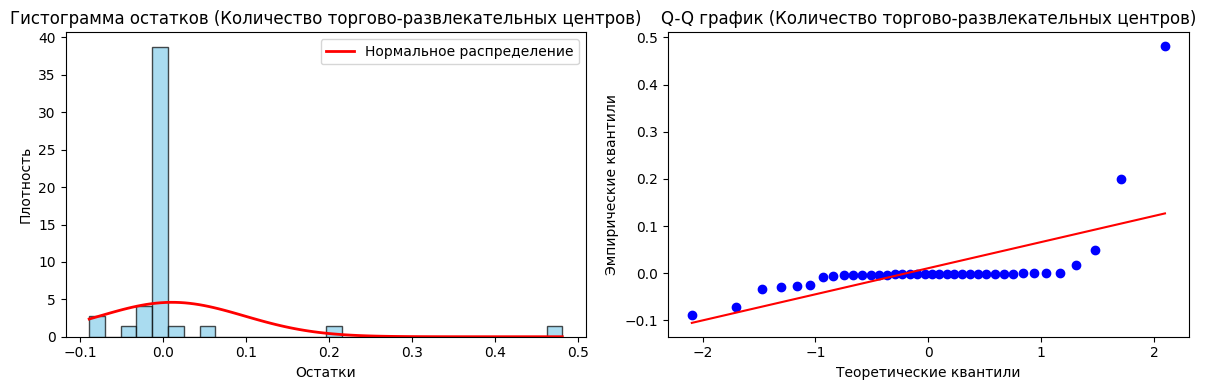


Анализ для Количество туристических баз:
Тест Шапиро-Уилка: статистика = 0.421, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Тест Колмогорова-Смирнова: статистика = 0.438, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Тест Андерсона-Дарлинга: статистика = 8.283
  => Остатки НЕ распределены нормально (статистика > 0.529 при уровне значимости 15.0%)
  => Остатки НЕ распределены нормально (статистика > 0.603 при уровне значимости 10.0%)
  => Остатки НЕ распределены нормально (статистика > 0.723 при уровне значимости 5.0%)
  => Остатки НЕ распределены нормально (статистика > 0.844 при уровне значимости 2.5%)
  => Остатки НЕ распределены нормально (статистика > 1.004 при уровне значимости 1.0%)
Тест Д’Агостино K²: статистика = 66.494, p-значение = 0.000
  => Остатки НЕ распределены нормально (p < 0.05)
Асимметрия (Skewness): 4.173 (должно быть близко к 0 для нормального)
Эксцесс (Kurtosis): 17.914 (должно быть близко к 0 для нормального)


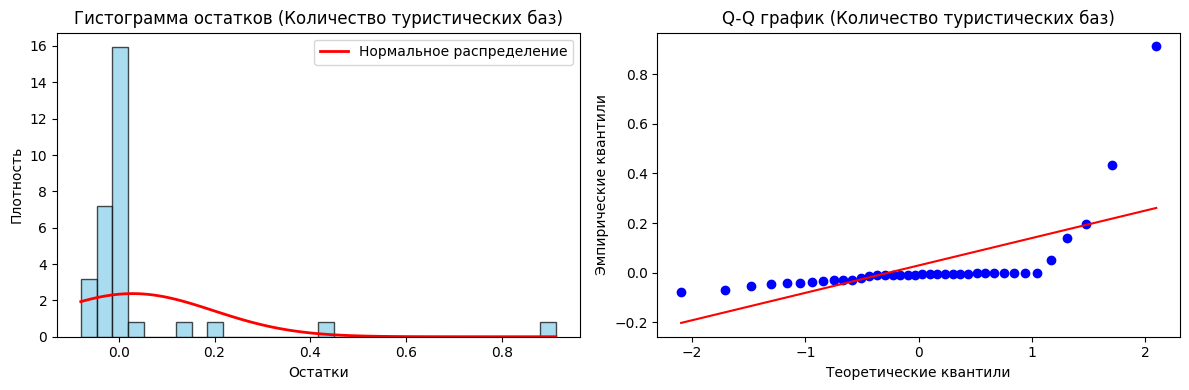


Анализ для Количество центров предоставления государственных и муниципальных услуг:
Тест Шапиро-Уилка: статистика = 0.975, p-значение = 0.533
  => Нет оснований отвергать нормальность (p >= 0.05)
Тест Колмогорова-Смирнова: статистика = 0.130, p-значение = 0.498
  => Нет оснований отвергать нормальность (p >= 0.05)
Тест Андерсона-Дарлинга: статистика = 0.491
  => Нет оснований отвергать нормальность (статистика <= 0.529 при уровне значимости 15.0%)
  => Нет оснований отвергать нормальность (статистика <= 0.603 при уровне значимости 10.0%)
  => Нет оснований отвергать нормальность (статистика <= 0.723 при уровне значимости 5.0%)
  => Нет оснований отвергать нормальность (статистика <= 0.844 при уровне значимости 2.5%)
  => Нет оснований отвергать нормальность (статистика <= 1.004 при уровне значимости 1.0%)
Тест Д’Агостино K²: статистика = 0.823, p-значение = 0.663
  => Нет оснований отвергать нормальность (p >= 0.05)
Асимметрия (Skewness): -0.174 (должно быть близко к 0 для нормального

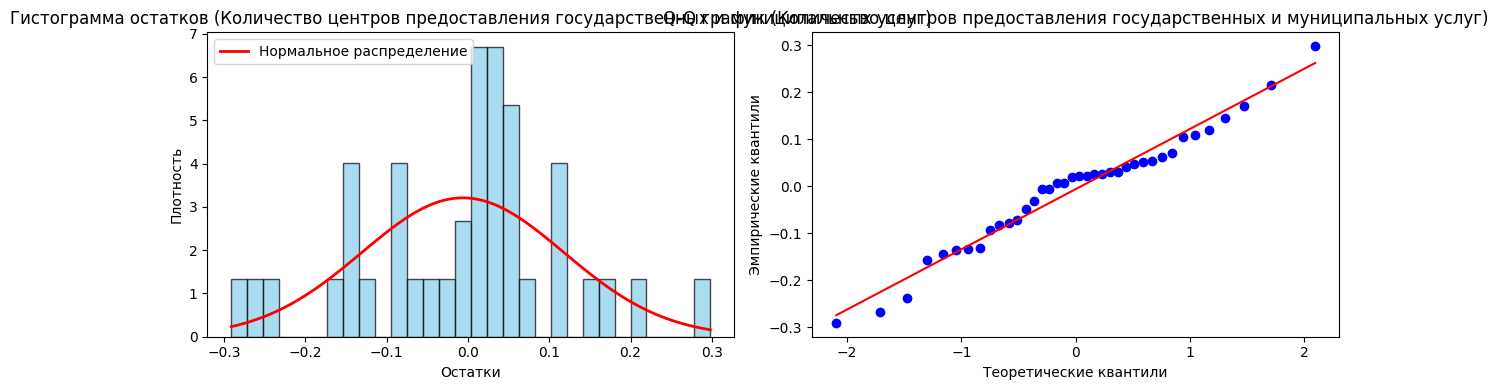

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro, kstest, anderson, normaltest
from scipy.stats import skew, kurtosis
import pandas as pd

def check_residuals_normality(y_test, y_pred, column=None):
    """
    Проверяет нормальность остатков для выбранной колонки или всех колонок с использованием
    визуальных методов и статистических тестов.
    
    Parameters:
    - y_test: Истинные значения (Pandas DataFrame, Series или NumPy массив).
    - y_pred: Предсказанные значения (Pandas DataFrame, Series или NumPy массив).
    - column: Имя или индекс колонки для анализа (по умолчанию None — все колонки).
    """
    
    # Преобразуем y_test и y_pred в массивы NumPy
    if hasattr(y_test, 'to_numpy'):
        y_test_np = y_test.to_numpy()
    else:
        y_test_np = np.array(y_test)

    if hasattr(y_pred, 'to_numpy'):
        y_pred_np = y_pred.to_numpy()
    else:
        y_pred_np = np.array(y_pred)

    # Проверяем соответствие размеров
    assert y_test_np.shape == y_pred_np.shape, f"Несоответствие форм: y_test {y_test_np.shape} != y_pred {y_pred_np.shape}"

    # Определяем количество колонок
    n_outputs = y_test_np.shape[1] if y_test_np.ndim > 1 else 1

    # Определяем имена колонок
    if hasattr(y_test, 'columns'):
        column_names = list(y_test.columns)
    else:
        column_names = [f'Целевая переменная {i+1}' for i in range(n_outputs)]

    # Выбор колонки
    if column is not None:
        if isinstance(column, str):
            if column not in column_names:
                raise ValueError(f"Колонка '{column}' не найдена. Доступные колонки: {column_names}")
            col_idx = column_names.index(column)
        elif isinstance(column, int):
            if column < 0 or column >= n_outputs:
                raise ValueError(f"Индекс колонки {column} вне диапазона [0, {n_outputs-1}]")
            col_idx = column
        else:
            raise ValueError("Параметр column должен быть строкой (имя колонки) или целым числом (индекс)")
        
        # Фильтруем данные для выбранной колонки
        y_test_np = y_test_np[:, col_idx:col_idx+1] if y_test_np.ndim > 1 else y_test_np[:, None]
        y_pred_np = y_pred_np[:, col_idx:col_idx+1] if y_pred_np.ndim > 1 else y_pred_np[:, None]
        column_names = [column_names[col_idx]]
        n_outputs = 1
    else:
        col_idx = None  # Анализируем все колонки

    # Рассчитываем остатки
    residuals = y_test_np - y_pred_np

    # Проверка нормальности для каждой целевой переменной
    for i in range(n_outputs):
        print(f'\nАнализ для {column_names[i]}:')

        # Извлекаем остатки для текущей колонки
        res = residuals[:, i]

        # 1. Тест Шапиро-Уилка
        stat, p_value = shapiro(res)
        print(f'Тест Шапиро-Уилка: статистика = {stat:.3f}, p-значение = {p_value:.3f}')
        if p_value < 0.05:
            print('  => Остатки НЕ распределены нормально (p < 0.05)')
        else:
            print('  => Нет оснований отвергать нормальность (p >= 0.05)')

        # 2. Тест Колмогорова-Смирнова
        stat, p_value = kstest(res, 'norm', args=(np.mean(res), np.std(res)))
        print(f'Тест Колмогорова-Смирнова: статистика = {stat:.3f}, p-значение = {p_value:.3f}')
        if p_value < 0.05:
            print('  => Остатки НЕ распределены нормально (p < 0.05)')
        else:
            print('  => Нет оснований отвергать нормальность (p >= 0.05)')

        # 3. Тест Андерсона-Дарлинга
        result = anderson(res, dist='norm')
        print(f'Тест Андерсона-Дарлинга: статистика = {result.statistic:.3f}')
        for crit_val, sig_level in zip(result.critical_values, result.significance_level):
            if result.statistic > crit_val:
                print(f'  => Остатки НЕ распределены нормально (статистика > {crit_val:.3f} при уровне значимости {sig_level}%)')
            else:
                print(f'  => Нет оснований отвергать нормальность (статистика <= {crit_val:.3f} при уровне значимости {sig_level}%)')

        # 4. Тест Д’Агостино K²
        stat, p_value = normaltest(res)
        print(f'Тест Д’Агостино K²: статистика = {stat:.3f}, p-значение = {p_value:.3f}')
        if p_value < 0.05:
            print('  => Остатки НЕ распределены нормально (p < 0.05)')
        else:
            print('  => Нет оснований отвергать нормальность (p >= 0.05)')

        # 5. Асимметрия и эксцесс
        skewness = skew(res)
        kurt = kurtosis(res, fisher=True)
        print(f'Асимметрия (Skewness): {skewness:.3f} (должно быть близко к 0 для нормального)')
        print(f'Эксцесс (Kurtosis): {kurt:.3f} (должно быть близко к 0 для нормального)')

        # 6. Визуализация
        plt.figure(figsize=(12, 4))

        # Гистограмма остатков
        plt.subplot(1, 2, 1)
        plt.hist(res, bins=30, alpha=0.7, color='skyblue', edgecolor='black', density=True)
        # Добавляем кривую нормального распределения
        mu, sigma = np.mean(res), np.std(res)
        x = np.linspace(min(res), max(res), 100)
        plt.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2, label='Нормальное распределение')
        plt.title(f'Гистограмма остатков ({column_names[i]})')
        plt.xlabel('Остатки')
        plt.ylabel('Плотность')
        plt.legend()

        # Q-Q график
        plt.subplot(1, 2, 2)
        stats.probplot(res, dist="norm", plot=plt)
        plt.title(f'Q-Q график ({column_names[i]})')
        plt.xlabel('Теоретические квантили')
        plt.ylabel('Эмпирические квантили')

        plt.tight_layout()
        plt.show()

# Пример использования
# Если y_test — DataFrame, можно выбрать по имени:
# check_residuals_normality(y_test, y_pred, column='target_1')

# Если y_test — NumPy массив, выбираем по индексу:
# check_residuals_normality(y_test, y_pred, column=0)

# Для всех колонок:
check_residuals_normality(y_test, y_pred)

Общая средняя важность признаков:
                  mean_importance
population               0.320391
living_area              0.217436
build_floor_area         0.128972
footprint_area           0.054729
non_living_area          0.054686
residential              0.039495
special                  0.037768
business                 0.035656
recreation               0.031904
site_area                0.030277
industrial               0.022116
agriculture              0.016960
transport                0.009611


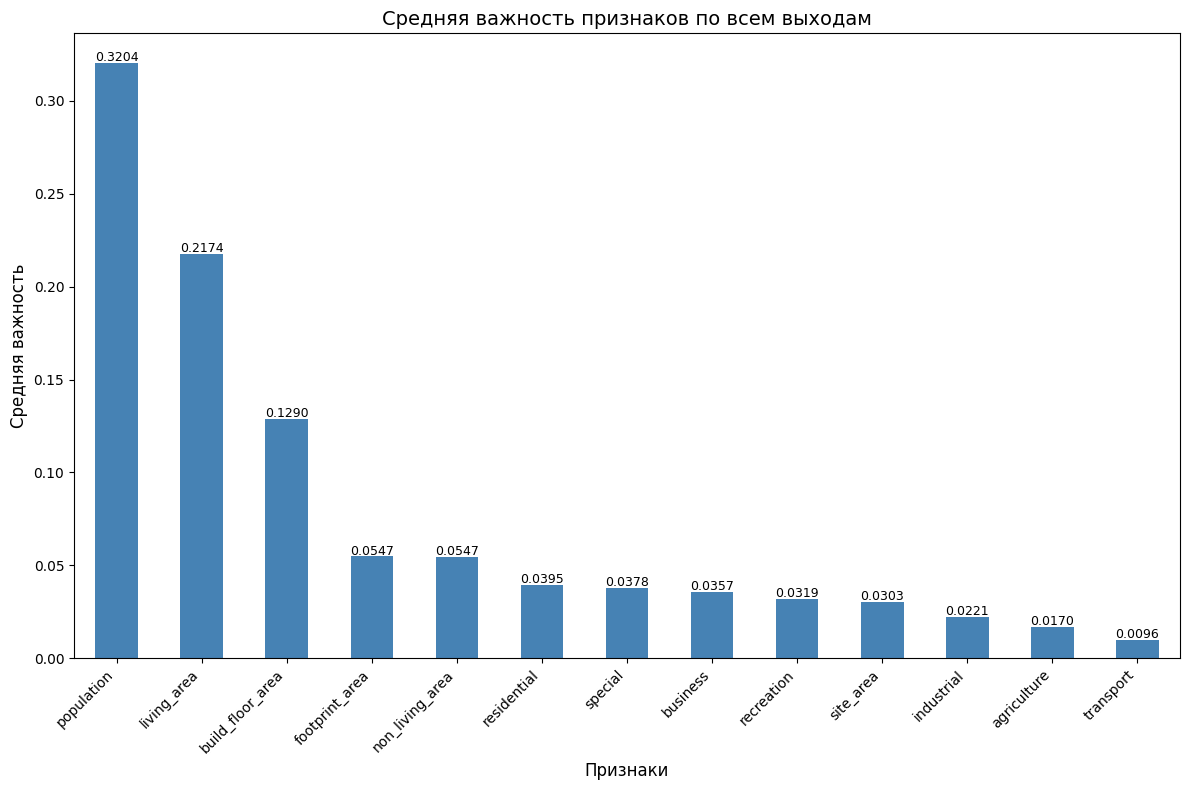

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Получение важности признаков
feature_importances = []
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"feature_{i}" for i in range(X_train.shape[1])]
output_names = y_train.columns if hasattr(y_train, 'columns') else [f"target_{i}" for i in range(y_train.shape[1])]

for i, estimator in enumerate(best_multi_gbr.estimators_):
    # Для каждого отдельного регрессора
    importances = estimator.feature_importances_
    feature_importances.append(importances)
    
    # Вывод важности для каждого выхода
    target_name = output_names[i]


feature_importance_df = pd.DataFrame(
    np.array(feature_importances).T,
    index=feature_names,
    columns=output_names
)

# Средняя важность по всем выходам
feature_importance_df['mean_importance'] = feature_importance_df.mean(axis=1)
feature_importance_df = feature_importance_df.sort_values('mean_importance', ascending=False)

print("Общая средняя важность признаков:")
print(feature_importance_df[['mean_importance']])

# Визуализация средней важности признаков
plt.figure(figsize=(12, 8))
ax = feature_importance_df['mean_importance'].plot(kind='bar', color='steelblue')
plt.title('Средняя важность признаков по всем выходам', fontsize=14)
plt.ylabel('Средняя важность', fontsize=12)
plt.xlabel('Признаки', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Добавляем значения над столбцами
for i, v in enumerate(feature_importance_df['mean_importance']):
    ax.text(i, v + 0.001, f'{v:.4f}', ha='center', fontsize=9)

plt.show()

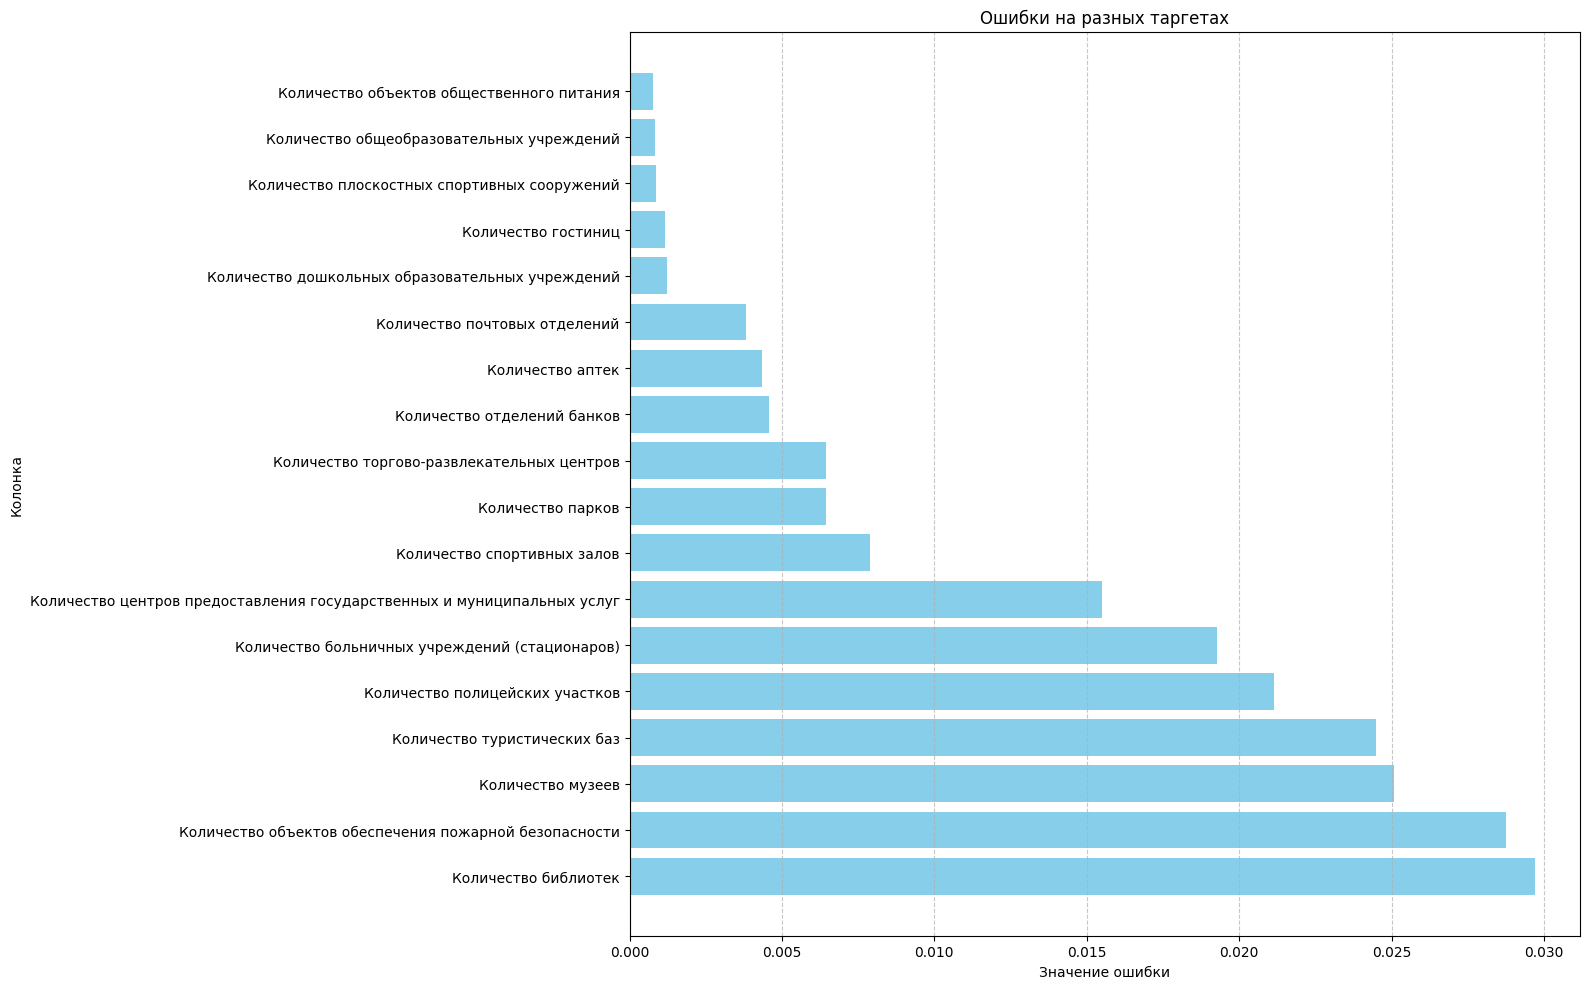

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Предположим, что mse — список значений ошибок, а Y.columns — список названий колонок
# Сортируем по убыванию
sorted_indices = np.argsort(mse)[::-1]
sorted_mse = np.array(mse)[sorted_indices]
sorted_columns = np.array(Y.columns)[sorted_indices]

# Построение горизонтальной гистограммы
plt.figure(figsize=(16, 10))
plt.barh(sorted_columns, sorted_mse, color='skyblue')

# Добавим подписи и заголовок
plt.ylabel('Колонка')
plt.xlabel('Значение ошибки')
plt.title('Ошибки на разных таргетах')

# Сетка и отображение
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [24]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lime.lime_tabular import LimeTabularExplainer

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Базовая модель GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)

# Обучение модели
gbr.fit(X_train, y_train['Количество объектов общественного питания'])

# Пример предсказания
y_pred = gbr.predict(X_test)

# Оценка качества
mse = mean_squared_error(y_test['Количество объектов общественного питания'], y_pred)
print(f'Mean Squared Error: {mse:.3f}')

# Создание LIME объяснителя для табличных данных
explainer = LimeTabularExplainer(
    training_data=X_train.values,  # Преобразуем DataFrame в numpy массив
    feature_names=X_train.columns,  # Указываем имена признаков
    class_names=[str(i) for i in range(y_train.shape[1])],  # Если многовыходная регрессия
    mode='regression',  # Тип задачи: регрессия
    random_state=42
)

# Выбираем одно наблюдение для интерпретации (например, первое из теста)
i = 0
instance = X_test.iloc[i].values.reshape(1, -1)

# Получаем объяснение для выбранного примера
explanation = explainer.explain_instance(instance[0], gbr.predict)

# Если нужно просто вывести данные:
print("Predicted value:", y_pred[i])
print('Real value:', y_test['Количество объектов общественного питания'].iloc[0])
print("Explanation:")
print(explanation.as_list())

Mean Squared Error: 0.002
Predicted value: 0.00458455175235364
Real value: 0.01020408163265306
Explanation:
[('0.00 < living_area <= 0.01', -0.041407013579319876), ('0.03 < build_floor_area <= 0.06', -0.01733933109995209), ('0.02 < population <= 0.04', -0.015114406755981677), ('0.00 < special <= 0.00', -0.011545044978551688), ('0.06 < non_living_area <= 0.12', -0.004833061619014718), ('business <= 0.00', -0.004568156948498945), ('0.03 < industrial <= 0.10', -0.0041039707290663205), ('0.01 < site_area <= 0.05', 0.003907472084179554), ('0.06 < agriculture <= 0.21', 0.003794057769607756), ('0.13 < residential <= 0.23', -0.0027106232196761676)]


/root/blocksnet/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


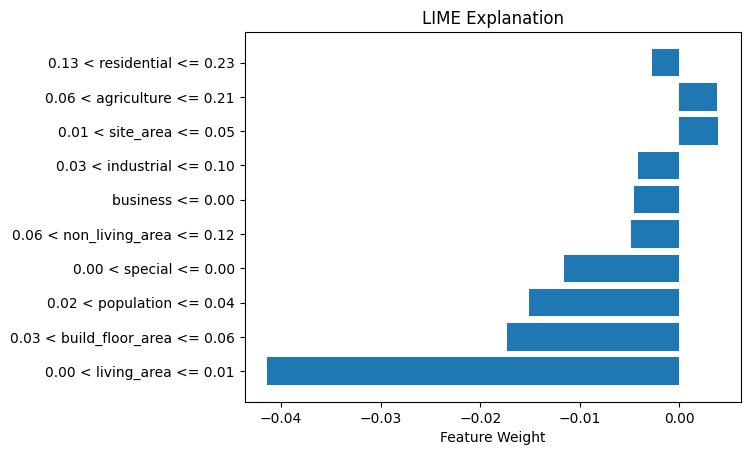

In [25]:
import matplotlib.pyplot as plt

# Получаем объяснение как список
explanation_list = explanation.as_list()

# Разбиваем объяснение на признаки и веса
features, weights = zip(*explanation_list)

# Строим график
plt.barh(features, weights)
plt.xlabel("Feature Weight")
plt.title("LIME Explanation")
plt.show()